In [1]:
import sys, os
PROJECT_ROOT = "../../../../.."
if os.path.abspath(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, os.path.abspath(PROJECT_ROOT))

In [2]:
# !pip install -e /mnt/user-home/git/coba
# !pip install vowpalwabbit

In [3]:
import itertools as it
import coba as cb
import matplotlib.pyplot as plt

## Evaluating Policies From Logged Data

A common task when working with logged bandit feedback is to estimate how well a new policy would perform in the logged environment.

To perform off policy evaluation there are three common estimators used in the literature:

  1. Inverse Propensity Score (IPS) -- a higher-variance lower-bias estimator
  2. Direct Method (DM) -- a lower-variance higher-bias estimator
  3. Doubly Robust (DR) -- a lower-variance lower-bias estimator
  
We will evaluate all three of these methods against ground truth using 208 simulated datasets.


#### 1. Create our evaluation data

To create our logged data we use a `MisguidedLearner`. This learner will behave very differently from the evaluation policies.

In [13]:
envs1 = cb.Environments.cache_dir('.coba_cache').from_template('../templates/class208.json',n_take=4_000,strict=True).chunk()
logs1 = envs1.logged(cb.MisguidedLearner(cb.VowpalEpsilonLearner(),1,-1)).shuffle().ope_rewards([None,'IPS','DM','DR']).cache()

#### 2. Define the experiment

In [5]:
experiment1 = cb.Experiment(logs1, cb.VowpalEpsilonLearner(), cb.OffPolicyEvaluator())

#### 3. Run the experiment

In [7]:
%%time
#WARNING: This can take some time to finish.
#WARNING: To simply see the results look below.
experiment1.run('out1.log.gz',processes=8,quiet=True)

Wall time: 9min 18s
{'Learners': 1, 'Environments': 832, 'Interactions': 2720000}


#### 4. Analyze the results

We plot the experimental results to see which one of our three options best utilized the logged data to predict online performance.

In [8]:
result1 = cb.Result.from_file('out1.log.gz')

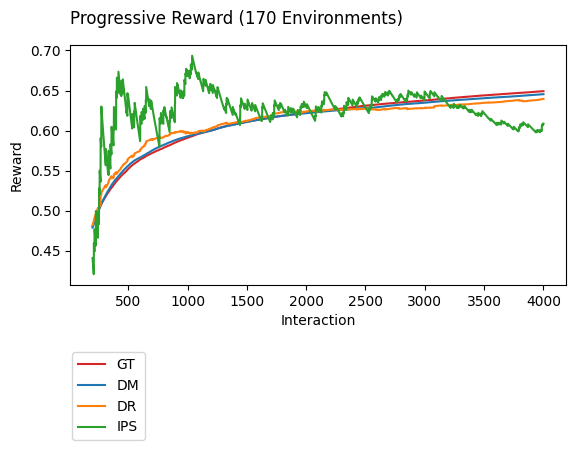

In [9]:
result1.filter_fin(4000).plot_learners(xlim=(200,None),l='ope_reward',p='openml_task',labels=['DM','DR','IPS','GT'])

In the plot above we can see how each of our reward estimators performed relative to the ground truth (GT). We know the ground truth  due to working with simulated data. In practice, when working with real world data, we won't know this value and will have to use a reward estimator such as DM, DR, or IPS instead.

Based on the plot above it appears that IPS estimates GT most poorly while DM estimates it best. This is not the full story though because what is plotted above is the average over all of our data sets and so it can hide extreme errors. By hidden extremes what we mean is this, imagine two people are trying to estimate the height of a five foot tall person. We will call our two people estimators. The first estimator guesses the person is 3' tall and 7' tall while the second estimator guesses the person is 4'11" and 5'1" tall. Now both of these people were correct on average (i.e., for both estimators their average estimate was 5' which was the ground truth) but one of them we could argue was a better estimator because not only were they right on average but their estimates were also close to the ground truth. This is what we mean by hidden extremes. To look for this we create a contrast plot.

[]

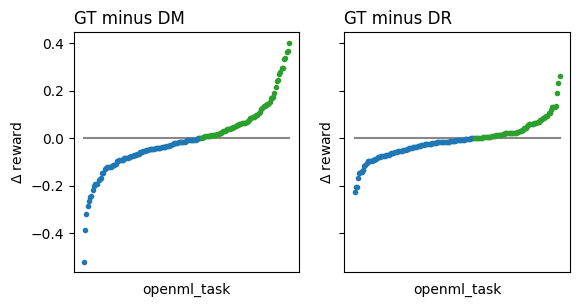

In [55]:
f,ax = plt.subplots(ncols=2,sharey=True)
result1.filter_fin(4000).plot_contrast('None','DM',x='openml_task',l='ope_reward',p='openml_task',err='sd',ax=ax[0],xticks=False,legend=False,out=None)
result1.filter_fin(4000).plot_contrast('None','DR',x='openml_task',l='ope_reward',p='openml_task',err='sd',ax=ax[1],xticks=False,legend=False,out=None)
ax[0].set_title('GT minus DM',loc='left')
ax[0].set_xticks([])
ax[1].set_title('GT minus DR',loc='left')
ax[1].set_xticks([])

The plot above shows the difference between the DM and DR estimator relative to GT on all of our datasets. This is the distribution of estimates that are being averaged over in the the first plot. Here we can see that the DR estimator has a very similar pattern to the DM estimator but more tamed extremes. To put it exactly, the DR error range from approximately -0.20 to 0.20 while the DM error ranges from -0.45 to .40. We can show this same result using the variance of our mean.

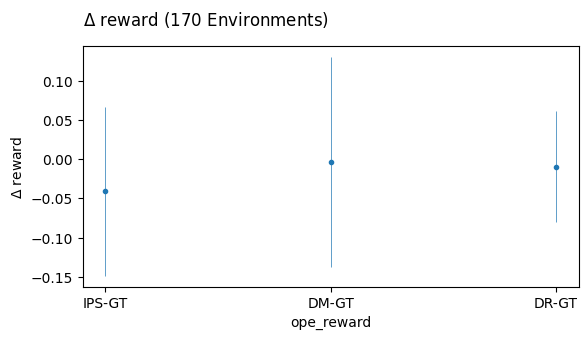

In [12]:
result1.filter_fin(4000).plot_contrast('None',['IPS','DM','DR'],x='ope_reward',l='ope_reward',p='openml_task',err='sd',boundary=False,legend=False,out=None)
plt.xticks(['IPS-None','DM-None','DR-None'],['IPS-GT','DM-GT','DR-GT'])
plt.show()

The plot above shows a point estimate for difference from ground truth for each of our estimators. That is, each point in this plot is equal to the difference between each estimator and ground truth in the first figure. The blue lines shows standard deviation of the estimates making up each point. We can see that the standard deviation for the DM-GT errors is much larger than the standard deviation for the DR-GT error. We can also see that while IPS is off base its standard deviation is a little smaller than DM. In fact as IPS gets more data it should begin to beat DM both in terms of error standard deviation and the average point estimate. We can actually see this happening if we create one more plot by interactions.

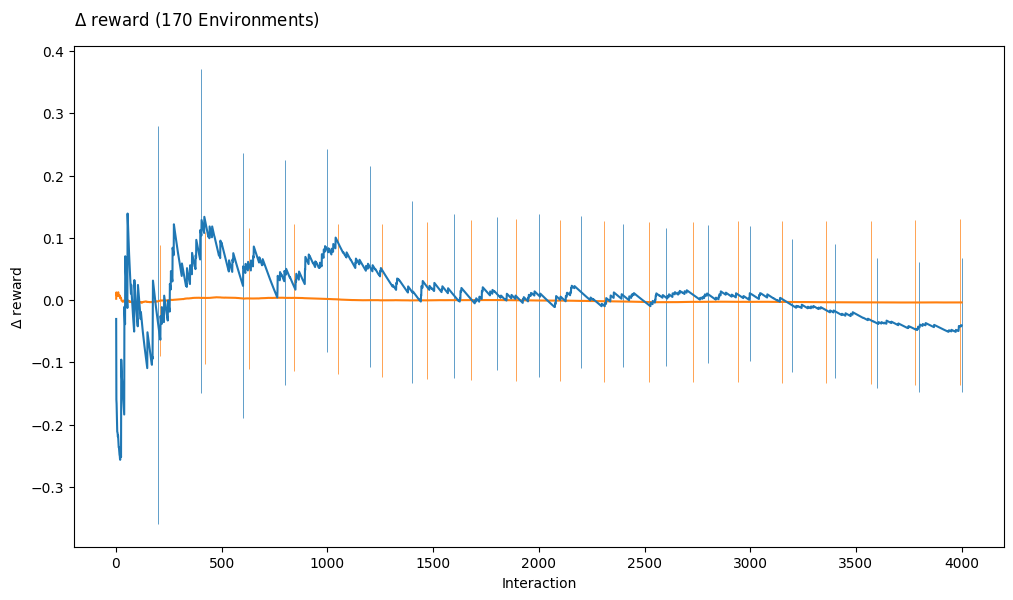

In [73]:
plt.figure(figsize=(12,10))
result1.filter_fin(4000).plot_contrast('None','DM',x='index',l='ope_reward', p='openml_task',colors=1,err='sd',errevery=210,boundary=False,out=None)
result1.filter_fin(4000).plot_contrast('None','IPS',x='index',l='ope_reward',p='openml_task',colors=0,err='sd',boundary=False,legend=False,out=None)

The plot above shows the average difference between ground truth and IPS/DM. The orange line is the DM error with standard deviations while the blue line is IPS error. We can see that DM error consistent. It doesn't improve, doesn't get worse. It starts out really good and just kidn of stays there. The IPS estimator on the other hand starts off pretty horribly and gets better and better. It's still not great by the end but this trend would continue. Given another 5,000 examples or so IPS would almost certainly do better than DM. And here's the secret to DR. Doubly robust is a combination of DM and IPS. So, it will start off strong like DM while also getting better and better with more data like IPS. 

---

## Evaluating Exploration From Logged

Our goal is to use logged data to estimate online exploration performance.

To do this we have three options:
  1. Perform on-policy evaluation using a reward estimator
  2. Perform off-policy evaluation using the logged data
  3. Use rejection sampling to make the logged data look like the desired exploration
  
We will evaluate all three options using logged data that we generate from a large set of classification datasets. By conducting this experiment over many datasets we can get a sense of the expected performance for each method independent of any one dataset. We will also intentionally use a misguided logging policy to generate our data to ensure that the logging policy doesn't look anything like the policies we wish to estimate.  

#### 1. Create evaluation data
To create our logged data we use a `MisguidedLearner`. This learner behaves very differently from the policies we want to evaluate.

In [4]:
envs2 = cb.Environments.cache_dir('.coba_cache').from_template('../templates/class208.json',n_take=1_000,strict=True).chunk()
logs2 = envs2.logged(cb.MisguidedLearner(cb.VowpalEpsilonLearner(),1,-1)).ope_rewards("DR").cache()

#### 2. Define the experiment 

In [5]:
ground_truth  = it.product(envs2,[cb.VowpalEpsilonLearner()],[cb.OnPolicyEvaluator()])
first_option  = it.product(logs2,[cb.VowpalEpsilonLearner()],[cb.OnPolicyEvaluator()])
second_option = it.product(logs2,[cb.VowpalEpsilonLearner()],[cb.OffPolicyEvaluator()])
third_option  = it.product(logs2,[cb.VowpalEpsilonLearner()],[cb.ExplorationEvaluator()])
ee_epsilon_50  = it.product(logs2,[cb.VowpalEpsilonLearner(epsilon=0.5)],[cb.ExplorationEvaluator()])

experiment2 = cb.Experiment(it.chain(ground_truth,first_option,second_option,third_option, ee_epsilon_50))

#### 3. Run the experiment

In [7]:
%%time
#WARNING: This can take some time to finish.
#WARNING: To simply see the results look below.
experiment2.run('out2.log.gz',processes=30,quiet=False)

2023-09-28 18:48:34 -- pid-152    -- Experiment Started
2023-09-28 18:48:34 -- pid-152    -- Restoring Results
2023-09-28 18:48:35 -- pid-474    -- Peeking at Environment 2... (0.02 seconds) (completed)
2023-09-28 18:48:35 -- pid-474    -- Environment 2 has nothing to evaluate (this is likely due to having too few interactions).
2023-09-28 18:48:35 -- pid-474    -- Peeking at Environment 210... (0.17 seconds) (completed)
2023-09-28 18:48:35 -- pid-474    -- Environment 210 has nothing to evaluate (this is likely due to having too few interactions).
2023-09-28 18:48:35 -- pid-474    -- Peeking at Environment 4... (0.02 seconds) (completed)
2023-09-28 18:48:35 -- pid-474    -- Environment 4 has nothing to evaluate (this is likely due to having too few interactions).
2023-09-28 18:48:35 -- pid-474    -- Peeking at Environment 212... (0.02 seconds) (completed)
2023-09-28 18:48:35 -- pid-474    -- Environment 212 has nothing to evaluate (this is likely due to having too few interactions).
2

2023-09-28 18:48:39 -- pid-515    -- Peeking at Environment 36... (2.02 seconds) (completed)
2023-09-28 18:48:39 -- pid-527    -- Evaluating Learner 3 on Environment 251... (0.13 seconds) (completed)
2023-09-28 18:48:39 -- pid-515    -- Evaluating Learner 0 on Environment 36... (0.35 seconds) (completed)
2023-09-28 18:48:40 -- pid-515    -- Peeking at Environment 244... (0.24 seconds) (completed)
2023-09-28 18:48:40 -- pid-515    -- Recording Environment 244 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:40 -- pid-515    -- Peeking at Environment 244... (0.24 seconds) (completed)
2023-09-28 18:48:40 -- pid-515    -- Evaluating Learner 1 on Environment 244... (0.3 seconds) (completed)
2023-09-28 18:48:40 -- pid-515    -- Peeking at Environment 244... (0.0 seconds) (completed)
2023-09-28 18:48:40 -- pid-515    -- Evaluating Learner 2 on Environment 244... (0.09 seconds) (exception)
2023-09-28 18:48:40 -- pid-515    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/

2023-09-28 18:48:44 -- pid-517    -- Peeking at Environment 37... (8.75 seconds) (completed)
2023-09-28 18:48:44 -- pid-517    -- Recording Environment 37 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:44 -- pid-533    -- Peeking at Environment 50... (7.67 seconds) (completed)
2023-09-28 18:48:44 -- pid-533    -- Recording Environment 50 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:44 -- pid-511    -- Peeking at Environment 33... (9.43 seconds) (completed)
2023-09-28 18:48:44 -- pid-511    -- Recording Environment 33 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:45 -- pid-503    -- Peeking at Environment 51... (8.1 seconds) (completed)
2023-09-28 18:48:45 -- pid-503    -- Recording Environment 51 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:45 -- pid-529    -- Peeking at Environment 44... (10.48 seconds) (completed)
2023-09-28 18:48:45 -- pid-529    -- Recording Environment 44 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:46 -- pi

2023-09-28 18:48:50 -- pid-478    -- Peeking at Environment 256... (0.26 seconds) (completed)
2023-09-28 18:48:50 -- pid-478    -- Recording Environment 256 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:50 -- pid-523    -- Evaluating Learner 0 on Environment 41... (0.29 seconds) (completed)
2023-09-28 18:48:50 -- pid-487    -- Evaluating Learner 0 on Environment 21... (0.28 seconds) (completed)
2023-09-28 18:48:50 -- pid-497    -- Evaluating Learner 1 on Environment 236... (0.38 seconds) (completed)
2023-09-28 18:48:50 -- pid-497    -- Peeking at Environment 236... (0.0 seconds) (completed)
2023-09-28 18:48:50 -- pid-531    -- Peeking at Environment 254... (0.25 seconds) (completed)
2023-09-28 18:48:50 -- pid-507    -- Peeking at Environment 34... (15.12 seconds) (completed)
2023-09-28 18:48:50 -- pid-507    -- Recording Environment 34 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:50 -- pid-523    -- Peeking at Environment 249... (0.21 seconds) (completed)
2023-09

2023-09-28 18:48:51 -- pid-474    -- Peeking at Environment 232... (0.26 seconds) (completed)
2023-09-28 18:48:51 -- pid-519    -- Evaluating Learner 0 on Environment 38... (0.63 seconds) (completed)
2023-09-28 18:48:51 -- pid-509    -- Evaluating Learner 1 on Environment 240... (0.26 seconds) (completed)
2023-09-28 18:48:51 -- pid-509    -- Peeking at Environment 240... (0.0 seconds) (completed)
2023-09-28 18:48:51 -- pid-497    -- Peeking at Environment 59... (0.33 seconds) (completed)
2023-09-28 18:48:51 -- pid-480    -- Peeking at Environment 49... (8.02 seconds) (completed)
2023-09-28 18:48:51 -- pid-509    -- Evaluating Learner 2 on Environment 240... (0.11 seconds) (exception)
2023-09-28 18:48:51 -- pid-509    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evalu

2023-09-28 18:48:53 -- pid-533    -- Peeking at Environment 258... (0.21 seconds) (completed)
2023-09-28 18:48:53 -- pid-517    -- Peeking at Environment 37... (8.99 seconds) (completed)
2023-09-28 18:48:53 -- pid-519    -- Evaluating Learner 3 on Environment 246... (0.19 seconds) (completed)
2023-09-28 18:48:53 -- pid-533    -- Evaluating Learner 1 on Environment 258... (0.2 seconds) (completed)
2023-09-28 18:48:53 -- pid-533    -- Peeking at Environment 258... (0.0 seconds) (completed)
2023-09-28 18:48:53 -- pid-533    -- Evaluating Learner 2 on Environment 258... (0.01 seconds) (exception)
2023-09-28 18:48:53 -- pid-533    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user-home/git

2023-09-28 18:48:54 -- pid-517    -- Peeking at Environment 72... (0.21 seconds) (completed)
2023-09-28 18:48:54 -- pid-517    -- Recording Environment 72 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:54 -- pid-511    -- Peeking at Environment 241... (0.19 seconds) (completed)
2023-09-28 18:48:54 -- pid-511    -- Recording Environment 241 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:54 -- pid-527    -- Evaluating Learner 0 on Environment 52... (0.14 seconds) (completed)
2023-09-28 18:48:54 -- pid-517    -- Peeking at Environment 72... (0.17 seconds) (completed)
2023-09-28 18:48:54 -- pid-499    -- Evaluating Learner 0 on Environment 71... (0.27 seconds) (completed)
2023-09-28 18:48:54 -- pid-511    -- Peeking at Environment 241... (0.19 seconds) (completed)
2023-09-28 18:48:54 -- pid-503    -- Evaluating Learner 1 on Environment 259... (0.28 seconds) (completed)
2023-09-28 18:48:54 -- pid-503    -- Peeking at Environment 259... (0.0 seconds) (completed)
2023-09-2

2023-09-28 18:48:55 -- pid-533    -- Evaluating Learner 3 on Environment 278... (0.18 seconds) (completed)
2023-09-28 18:48:55 -- pid-527    -- Peeking at Environment 78... (0.31 seconds) (completed)
2023-09-28 18:48:55 -- pid-527    -- Recording Environment 78 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:55 -- pid-489    -- Evaluating Learner 3 on Environment 230... (0.42 seconds) (completed)
2023-09-28 18:48:55 -- pid-519    -- Evaluating Learner 0 on Environment 69... (0.42 seconds) (completed)
2023-09-28 18:48:55 -- pid-499    -- Evaluating Learner 1 on Environment 279... (0.42 seconds) (completed)
2023-09-28 18:48:55 -- pid-499    -- Peeking at Environment 279... (0.0 seconds) (completed)
2023-09-28 18:48:55 -- pid-499    -- Evaluating Learner 2 on Environment 279... (0.01 seconds) (exception)
2023-09-28 18:48:55 -- pid-499    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, va

2023-09-28 18:48:57 -- pid-487    -- Peeking at Environment 62... (6.37 seconds) (completed)
2023-09-28 18:48:57 -- pid-487    -- Recording Environment 62 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:57 -- pid-529    -- Evaluating Learner 0 on Environment 44... (0.89 seconds) (completed)
2023-09-28 18:48:57 -- pid-517    -- Evaluating Learner 3 on Environment 280... (0.28 seconds) (completed)
2023-09-28 18:48:57 -- pid-509    -- Peeking at Environment 65... (6.05 seconds) (completed)
2023-09-28 18:48:57 -- pid-509    -- Recording Environment 65 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:58 -- pid-474    -- Peeking at Environment 66... (6.18 seconds) (completed)
2023-09-28 18:48:58 -- pid-474    -- Recording Environment 66 parameters... (0.0 seconds) (completed)
2023-09-28 18:48:58 -- pid-485    -- Peeking at Environment 54... (7.8 seconds) (completed)
2023-09-28 18:48:58 -- pid-529    -- Peeking at Environment 252... (0.8 seconds) (completed)
2023-09-28 18:48:

2023-09-28 18:49:02 -- pid-533    -- Peeking at Environment 79... (7.08 seconds) (completed)
2023-09-28 18:49:02 -- pid-533    -- Recording Environment 79 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:02 -- pid-523    -- Evaluating Learner 3 on Environment 271... (0.17 seconds) (completed)
2023-09-28 18:49:02 -- pid-489    -- Evaluating Learner 1 on Environment 291... (0.31 seconds) (completed)
2023-09-28 18:49:02 -- pid-489    -- Peeking at Environment 291... (0.0 seconds) (completed)
2023-09-28 18:49:02 -- pid-489    -- Evaluating Learner 2 on Environment 291... (0.01 seconds) (exception)
2023-09-28 18:49:02 -- pid-489    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user

2023-09-28 18:49:04 -- pid-523    -- Peeking at Environment 89... (1.06 seconds) (completed)
2023-09-28 18:49:04 -- pid-515    -- Peeking at Environment 263... (0.21 seconds) (completed)
2023-09-28 18:49:04 -- pid-515    -- Recording Environment 263 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:05 -- pid-525    -- Peeking at Environment 42... (14.92 seconds) (completed)
2023-09-28 18:49:05 -- pid-493    -- Peeking at Environment 265... (0.33 seconds) (completed)
2023-09-28 18:49:05 -- pid-493    -- Recording Environment 265 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:05 -- pid-523    -- Evaluating Learner 0 on Environment 89... (0.25 seconds) (completed)
2023-09-28 18:49:05 -- pid-515    -- Peeking at Environment 263... (0.21 seconds) (completed)
2023-09-28 18:49:05 -- pid-487    -- Peeking at Environment 270... (0.44 seconds) (completed)
2023-09-28 18:49:05 -- pid-515    -- Evaluating Learner 1 on Environment 263... (0.22 seconds) (completed)
2023-09-28 18:49:0

2023-09-28 18:49:06 -- pid-525    -- Evaluating Learner 3 on Environment 250... (0.11 seconds) (completed)
2023-09-28 18:49:06 -- pid-507    -- Evaluating Learner 0 on Environment 34... (0.87 seconds) (completed)
2023-09-28 18:49:06 -- pid-525    -- Peeking at Environment 99... (0.05 seconds) (completed)
2023-09-28 18:49:06 -- pid-525    -- Recording Environment 99 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:06 -- pid-525    -- Peeking at Environment 99... (0.02 seconds) (completed)
2023-09-28 18:49:06 -- pid-525    -- Environment 99 has nothing to evaluate (this is likely due to having too few interactions).
2023-09-28 18:49:06 -- pid-525    -- Peeking at Environment 307... (0.02 seconds) (completed)
2023-09-28 18:49:06 -- pid-525    -- Recording Environment 307 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:06 -- pid-521    -- Peeking at Environment 268... (0.24 seconds) (completed)
2023-09-28 18:49:06 -- pid-521    -- Recording Environment 268 parameters... (0

2023-09-28 18:49:07 -- pid-531    -- Peeking at Environment 104... (0.06 seconds) (completed)
2023-09-28 18:49:07 -- pid-531    -- Recording Environment 104 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:07 -- pid-531    -- Peeking at Environment 104... (0.02 seconds) (completed)
2023-09-28 18:49:07 -- pid-531    -- Environment 104 has nothing to evaluate (this is likely due to having too few interactions).
2023-09-28 18:49:07 -- pid-531    -- Peeking at Environment 312... (0.02 seconds) (completed)
2023-09-28 18:49:07 -- pid-531    -- Recording Environment 312 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:07 -- pid-487    -- Peeking at Environment 96... (0.87 seconds) (completed)
2023-09-28 18:49:07 -- pid-531    -- Peeking at Environment 312... (0.02 seconds) (completed)
2023-09-28 18:49:07 -- pid-531    -- Environment 312 has nothing to evaluate (this is likely due to having too few interactions).
2023-09-28 18:49:07 -- pid-525    -- Peeking at Environment 103..

2023-09-28 18:49:09 -- pid-482    -- Evaluating Learner 3 on Environment 235... (0.33 seconds) (completed)
2023-09-28 18:49:09 -- pid-531    -- Evaluating Learner 1 on Environment 315... (0.17 seconds) (completed)
2023-09-28 18:49:09 -- pid-531    -- Peeking at Environment 315... (0.0 seconds) (completed)
2023-09-28 18:49:09 -- pid-531    -- Evaluating Learner 2 on Environment 315... (0.01 seconds) (exception)
2023-09-28 18:49:09 -- pid-531    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user-home/git/coba/coba/utilities.py", line 164, in sample_actions
    probability = probabilities_normalized[action_space.index(action)]

  ValueError: The truth value of an array with more than one

2023-09-28 18:49:10 -- pid-482    -- Evaluating Learner 1 on Environment 318... (0.18 seconds) (completed)
2023-09-28 18:49:10 -- pid-482    -- Peeking at Environment 318... (0.0 seconds) (completed)
2023-09-28 18:49:10 -- pid-482    -- Evaluating Learner 2 on Environment 318... (0.01 seconds) (exception)
2023-09-28 18:49:10 -- pid-482    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user-home/git/coba/coba/utilities.py", line 164, in sample_actions
    probability = probabilities_normalized[action_space.index(action)]

  ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

2023-09-28 18:49:10 -- pid-482    -- Peeking at Environment 

2023-09-28 18:49:11 -- pid-511    -- Peeking at Environment 321... (0.16 seconds) (completed)
2023-09-28 18:49:11 -- pid-511    -- Recording Environment 321 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:11 -- pid-507    -- Peeking at Environment 115... (0.26 seconds) (completed)
2023-09-28 18:49:11 -- pid-507    -- Recording Environment 115 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:11 -- pid-533    -- Evaluating Learner 3 on Environment 287... (0.13 seconds) (completed)
2023-09-28 18:49:11 -- pid-495    -- Peeking at Environment 234... (0.82 seconds) (completed)
2023-09-28 18:49:11 -- pid-495    -- Recording Environment 234 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:11 -- pid-525    -- Peeking at Environment 117... (0.17 seconds) (completed)
2023-09-28 18:49:11 -- pid-525    -- Recording Environment 117 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:11 -- pid-482    -- Peeking at Environment 322... (0.15 seconds) (completed)
2023-09-28 

2023-09-28 18:49:12 -- pid-495    -- Peeking at Environment 234... (0.81 seconds) (completed)
2023-09-28 18:49:12 -- pid-507    -- Evaluating Learner 1 on Environment 323... (0.18 seconds) (completed)
2023-09-28 18:49:12 -- pid-507    -- Peeking at Environment 323... (0.0 seconds) (completed)
2023-09-28 18:49:12 -- pid-507    -- Evaluating Learner 2 on Environment 323... (0.01 seconds) (exception)
2023-09-28 18:49:12 -- pid-507    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user-home/git/coba/coba/utilities.py", line 164, in sample_actions
    probability = probabilities_normalized[action_space.index(action)]

  ValueError: The truth value of an array with more than one element is a

2023-09-28 18:49:12 -- pid-480    -- Peeking at Environment 332... (0.16 seconds) (completed)
2023-09-28 18:49:12 -- pid-480    -- Recording Environment 332 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:12 -- pid-511    -- Peeking at Environment 329... (0.16 seconds) (completed)
2023-09-28 18:49:12 -- pid-511    -- Recording Environment 329 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:12 -- pid-527    -- Evaluating Learner 0 on Environment 127... (0.13 seconds) (completed)
2023-09-28 18:49:12 -- pid-482    -- Peeking at Environment 330... (0.16 seconds) (completed)
2023-09-28 18:49:12 -- pid-482    -- Recording Environment 330 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:12 -- pid-507    -- Evaluating Learner 0 on Environment 125... (0.13 seconds) (completed)
2023-09-28 18:49:12 -- pid-531    -- Peeking at Environment 129... (0.19 seconds) (completed)
2023-09-28 18:49:12 -- pid-531    -- Recording Environment 129 parameters... (0.0 seconds) (completed

2023-09-28 18:49:13 -- pid-507    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user-home/git/coba/coba/utilities.py", line 164, in sample_actions
    probability = probabilities_normalized[action_space.index(action)]

  ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

2023-09-28 18:49:13 -- pid-507    -- Peeking at Environment 333... (0.0 seconds) (completed)
2023-09-28 18:49:13 -- pid-482    -- Peeking at Environment 342... (0.02 seconds) (completed)
2023-09-28 18:49:13 -- pid-482    -- Environment 342 has nothing to evaluate (this is likely due to having too few interactions).
2023-09-28 18:49:13 -- pid-495    -- Evaluating Le

2023-09-28 18:49:13 -- pid-480    -- Evaluating Learner 1 on Environment 340... (0.2 seconds) (completed)
2023-09-28 18:49:13 -- pid-480    -- Peeking at Environment 340... (0.0 seconds) (completed)
2023-09-28 18:49:13 -- pid-480    -- Evaluating Learner 2 on Environment 340... (0.01 seconds) (exception)
2023-09-28 18:49:13 -- pid-480    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user-home/git/coba/coba/utilities.py", line 164, in sample_actions
    probability = probabilities_normalized[action_space.index(action)]

  ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

2023-09-28 18:49:13 -- pid-480    -- Peeking at Environment 3

2023-09-28 18:49:14 -- pid-495    -- Peeking at Environment 347... (0.18 seconds) (completed)
2023-09-28 18:49:14 -- pid-487    -- Evaluating Learner 3 on Environment 348... (0.07 seconds) (completed)
2023-09-28 18:49:14 -- pid-511    -- Peeking at Environment 145... (0.39 seconds) (completed)
2023-09-28 18:49:14 -- pid-527    -- Evaluating Learner 0 on Environment 144... (0.12 seconds) (completed)
2023-09-28 18:49:14 -- pid-519    -- Peeking at Environment 84... (8.61 seconds) (completed)
2023-09-28 18:49:14 -- pid-511    -- Evaluating Learner 0 on Environment 145... (0.15 seconds) (completed)
2023-09-28 18:49:14 -- pid-495    -- Evaluating Learner 1 on Environment 347... (0.2 seconds) (completed)
2023-09-28 18:49:14 -- pid-495    -- Peeking at Environment 347... (0.0 seconds) (completed)
2023-09-28 18:49:14 -- pid-495    -- Evaluating Learner 2 on Environment 347... (0.01 seconds) (exception)
2023-09-28 18:49:14 -- pid-495    -- Unexpected exception:

  File "/mnt/user-home/git/coba/

2023-09-28 18:49:15 -- pid-491    -- Peeking at Environment 76... (10.0 seconds) (completed)
2023-09-28 18:49:15 -- pid-519    -- Recording Environment 153 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:15 -- pid-499    -- Peeking at Environment 289... (0.19 seconds) (completed)
2023-09-28 18:49:15 -- pid-519    -- Peeking at Environment 153... (0.08 seconds) (completed)
2023-09-28 18:49:15 -- pid-495    -- Peeking at Environment 358... (0.22 seconds) (completed)
2023-09-28 18:49:15 -- pid-511    -- Evaluating Learner 0 on Environment 152... (0.19 seconds) (completed)
2023-09-28 18:49:16 -- pid-499    -- Evaluating Learner 1 on Environment 289... (0.2 seconds) (completed)
2023-09-28 18:49:16 -- pid-499    -- Peeking at Environment 289... (0.0 seconds) (completed)
2023-09-28 18:49:16 -- pid-499    -- Evaluating Learner 2 on Environment 289... (0.01 seconds) (exception)
2023-09-28 18:49:16 -- pid-499    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/

2023-09-28 18:49:16 -- pid-511    -- Peeking at Environment 158... (0.11 seconds) (completed)
2023-09-28 18:49:16 -- pid-511    -- Recording Environment 158 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:16 -- pid-519    -- Evaluating Learner 3 on Environment 361... (0.1 seconds) (completed)
2023-09-28 18:49:16 -- pid-511    -- Peeking at Environment 158... (0.05 seconds) (completed)
2023-09-28 18:49:17 -- pid-529    -- Peeking at Environment 365... (0.15 seconds) (completed)
2023-09-28 18:49:17 -- pid-499    -- Evaluating Learner 1 on Environment 362... (0.19 seconds) (completed)
2023-09-28 18:49:17 -- pid-499    -- Peeking at Environment 362... (0.0 seconds) (completed)
2023-09-28 18:49:17 -- pid-499    -- Evaluating Learner 2 on Environment 362... (0.01 seconds) (exception)
2023-09-28 18:49:17 -- pid-499    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluato

2023-09-28 18:49:17 -- pid-523    -- Peeking at Environment 98... (11.71 seconds) (completed)
2023-09-28 18:49:17 -- pid-523    -- Recording Environment 98 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:17 -- pid-519    -- Evaluating Learner 3 on Environment 367... (0.07 seconds) (completed)
2023-09-28 18:49:17 -- pid-491    -- Peeking at Environment 164... (0.18 seconds) (completed)
2023-09-28 18:49:17 -- pid-499    -- Peeking at Environment 368... (0.23 seconds) (completed)
2023-09-28 18:49:18 -- pid-489    -- Evaluating Learner 0 on Environment 90... (0.22 seconds) (completed)
2023-09-28 18:49:18 -- pid-519    -- Peeking at Environment 166... (0.14 seconds) (completed)
2023-09-28 18:49:18 -- pid-519    -- Recording Environment 166 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:18 -- pid-495    -- Peeking at Environment 155... (0.89 seconds) (completed)
2023-09-28 18:49:18 -- pid-519    -- Peeking at Environment 166... (0.1 seconds) (completed)
2023-09-28 18:49:18

2023-09-28 18:49:19 -- pid-489    -- Evaluating Learner 0 on Environment 169... (0.12 seconds) (completed)
2023-09-28 18:49:19 -- pid-519    -- Evaluating Learner 3 on Environment 374... (0.1 seconds) (completed)
2023-09-28 18:49:19 -- pid-519    -- Peeking at Environment 170... (0.07 seconds) (completed)
2023-09-28 18:49:19 -- pid-519    -- Recording Environment 170 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:19 -- pid-499    -- Evaluating Learner 1 on Environment 375... (0.19 seconds) (completed)
2023-09-28 18:49:19 -- pid-499    -- Peeking at Environment 375... (0.0 seconds) (completed)
2023-09-28 18:49:19 -- pid-499    -- Evaluating Learner 2 on Environment 375... (0.01 seconds) (exception)
2023-09-28 18:49:19 -- pid-499    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online

2023-09-28 18:49:20 -- pid-529    -- Peeking at Environment 369... (0.15 seconds) (completed)
2023-09-28 18:49:20 -- pid-501    -- Peeking at Environment 376... (0.4 seconds) (completed)
2023-09-28 18:49:20 -- pid-499    -- Peeking at Environment 380... (0.2 seconds) (completed)
2023-09-28 18:49:20 -- pid-499    -- Recording Environment 380 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:20 -- pid-489    -- Peeking at Environment 381... (0.19 seconds) (completed)
2023-09-28 18:49:20 -- pid-489    -- Recording Environment 381 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:20 -- pid-480    -- Peeking at Environment 175... (0.09 seconds) (completed)
2023-09-28 18:49:20 -- pid-476    -- Peeking at Environment 93... (7.68 seconds) (completed)
2023-09-28 18:49:20 -- pid-529    -- Evaluating Learner 1 on Environment 369... (0.16 seconds) (completed)
2023-09-28 18:49:20 -- pid-529    -- Peeking at Environment 369... (0.0 seconds) (completed)
2023-09-28 18:49:20 -- pid-529   

2023-09-28 18:49:20 -- pid-529    -- Peeking at Environment 177... (0.17 seconds) (completed)
2023-09-28 18:49:20 -- pid-511    -- Peeking at Environment 373... (0.4 seconds) (completed)
2023-09-28 18:49:21 -- pid-501    -- Evaluating Learner 3 on Environment 376... (0.16 seconds) (completed)
2023-09-28 18:49:21 -- pid-519    -- Evaluating Learner 0 on Environment 176... (0.14 seconds) (completed)
2023-09-28 18:49:21 -- pid-480    -- Peeking at Environment 383... (0.36 seconds) (completed)
2023-09-28 18:49:21 -- pid-480    -- Recording Environment 383 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:21 -- pid-476    -- Evaluating Learner 1 on Environment 301... (0.18 seconds) (completed)
2023-09-28 18:49:21 -- pid-476    -- Peeking at Environment 301... (0.0 seconds) (completed)
2023-09-28 18:49:21 -- pid-476    -- Evaluating Learner 2 on Environment 301... (0.01 seconds) (exception)
2023-09-28 18:49:21 -- pid-476    -- Unexpected exception:

  File "/mnt/user-home/git/coba/cob

2023-09-28 18:49:22 -- pid-529    -- Evaluating Learner 1 on Environment 385... (0.35 seconds) (completed)
2023-09-28 18:49:22 -- pid-529    -- Peeking at Environment 385... (0.0 seconds) (completed)
2023-09-28 18:49:22 -- pid-529    -- Evaluating Learner 2 on Environment 385... (0.01 seconds) (exception)
2023-09-28 18:49:22 -- pid-507    -- Evaluating Learner 0 on Environment 138... (0.78 seconds) (completed)
2023-09-28 18:49:22 -- pid-497    -- Evaluating Learner 0 on Environment 67... (0.7 seconds) (completed)
2023-09-28 18:49:22 -- pid-529    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user-home/git/coba/coba/utilities.py", line 164, in sample_actions
    probability = probabili

2023-09-28 18:49:23 -- pid-497    -- Peeking at Environment 275... (0.74 seconds) (completed)
2023-09-28 18:49:23 -- pid-485    -- Peeking at Environment 86... (11.58 seconds) (completed)
2023-09-28 18:49:23 -- pid-509    -- Evaluating Learner 0 on Environment 92... (0.19 seconds) (completed)
2023-09-28 18:49:23 -- pid-476    -- Evaluating Learner 1 on Environment 391... (0.72 seconds) (completed)
2023-09-28 18:49:23 -- pid-476    -- Peeking at Environment 391... (0.0 seconds) (completed)
2023-09-28 18:49:23 -- pid-476    -- Evaluating Learner 2 on Environment 391... (0.01 seconds) (exception)
2023-09-28 18:49:23 -- pid-476    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user-home/gi

2023-09-28 18:49:25 -- pid-533    -- Peeking at Environment 355... (0.19 seconds) (completed)
2023-09-28 18:49:25 -- pid-531    -- Peeking at Environment 141... (11.44 seconds) (completed)
2023-09-28 18:49:25 -- pid-531    -- Recording Environment 141 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:25 -- pid-527    -- Peeking at Environment 359... (2.01 seconds) (completed)
2023-09-28 18:49:25 -- pid-533    -- Evaluating Learner 1 on Environment 355... (0.21 seconds) (completed)
2023-09-28 18:49:25 -- pid-533    -- Peeking at Environment 355... (0.0 seconds) (completed)
2023-09-28 18:49:25 -- pid-533    -- Evaluating Learner 2 on Environment 355... (0.01 seconds) (exception)
2023-09-28 18:49:25 -- pid-533    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evalu

2023-09-28 18:49:26 -- pid-507    -- Peeking at Environment 406... (0.16 seconds) (completed)
2023-09-28 18:49:26 -- pid-507    -- Recording Environment 406 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:26 -- pid-503    -- Evaluating Learner 0 on Environment 149... (0.31 seconds) (completed)
2023-09-28 18:49:26 -- pid-489    -- Peeking at Environment 403... (0.39 seconds) (completed)
2023-09-28 18:49:26 -- pid-489    -- Recording Environment 403 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:26 -- pid-497    -- Evaluating Learner 1 on Environment 404... (0.4 seconds) (completed)
2023-09-28 18:49:26 -- pid-497    -- Peeking at Environment 404... (0.0 seconds) (completed)
2023-09-28 18:49:26 -- pid-497    -- Evaluating Learner 2 on Environment 404... (0.01 seconds) (exception)
2023-09-28 18:49:26 -- pid-497    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(Saf

2023-09-28 18:49:27 -- pid-507    -- Peeking at Environment 414... (0.21 seconds) (completed)
2023-09-28 18:49:27 -- pid-497    -- Evaluating Learner 1 on Environment 413... (0.17 seconds) (completed)
2023-09-28 18:49:27 -- pid-497    -- Peeking at Environment 413... (0.0 seconds) (completed)
2023-09-28 18:49:27 -- pid-497    -- Evaluating Learner 2 on Environment 413... (0.0 seconds) (exception)
2023-09-28 18:49:27 -- pid-497    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user-home/git/coba/coba/utilities.py", line 164, in sample_actions
    probability = probabilities_normalized[action_space.index(action)]

  ValueError: The truth value of an array with more than one element is am

2023-09-28 18:49:28 -- pid-485    -- Evaluating Learner 1 on Environment 405... (0.19 seconds) (completed)
2023-09-28 18:49:28 -- pid-485    -- Peeking at Environment 405... (0.0 seconds) (completed)
2023-09-28 18:49:28 -- pid-485    -- Evaluating Learner 2 on Environment 405... (0.01 seconds) (exception)
2023-09-28 18:49:28 -- pid-485    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user-home/git/coba/coba/utilities.py", line 164, in sample_actions
    probability = probabilities_normalized[action_space.index(action)]

  ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

2023-09-28 18:49:28 -- pid-485    -- Peeking at Environment 

2023-09-28 18:49:29 -- pid-523    -- Peeking at Environment 98... (11.41 seconds) (completed)
2023-09-28 18:49:29 -- pid-523    -- Evaluating Learner 0 on Environment 98... (0.16 seconds) (completed)
2023-09-28 18:49:29 -- pid-495    -- Peeking at Environment 184... (7.88 seconds) (completed)
2023-09-28 18:49:29 -- pid-495    -- Recording Environment 184 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:29 -- pid-503    -- Peeking at Environment 225... (0.72 seconds) (completed)
2023-09-28 18:49:29 -- pid-503    -- Evaluating Learner 2 on Environment 225... (0.0 seconds) (exception)
2023-09-28 18:49:29 -- pid-503    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user-home/git/co

2023-09-28 18:49:35 -- pid-519    -- Peeking at Environment 185... (6.69 seconds) (completed)
2023-09-28 18:49:35 -- pid-521    -- Evaluating Learner 3 on Environment 400... (0.06 seconds) (completed)
2023-09-28 18:49:35 -- pid-501    -- Peeking at Environment 181... (7.37 seconds) (completed)
2023-09-28 18:49:35 -- pid-519    -- Evaluating Learner 0 on Environment 185... (0.73 seconds) (completed)
2023-09-28 18:49:35 -- pid-480    -- Peeking at Environment 187... (13.83 seconds) (completed)
2023-09-28 18:49:35 -- pid-480    -- Recording Environment 187 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:36 -- pid-501    -- Evaluating Learner 0 on Environment 181... (0.15 seconds) (completed)
2023-09-28 18:49:36 -- pid-531    -- Peeking at Environment 141... (11.07 seconds) (completed)
2023-09-28 18:49:36 -- pid-501    -- Peeking at Environment 389... (0.2 seconds) (completed)
2023-09-28 18:49:36 -- pid-501    -- Recording Environment 389 parameters... (0.0 seconds) (completed)
20

2023-09-28 18:49:37 -- pid-513    -- Evaluating Learner 0 on Environment 88... (0.2 seconds) (completed)
2023-09-28 18:49:37 -- pid-495    -- Peeking at Environment 392... (0.43 seconds) (completed)
2023-09-28 18:49:37 -- pid-495    -- Recording Environment 392 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:37 -- pid-513    -- Peeking at Environment 296... (0.27 seconds) (completed)
2023-09-28 18:49:37 -- pid-513    -- Recording Environment 296 parameters... (0.0 seconds) (completed)
2023-09-28 18:49:38 -- pid-513    -- Peeking at Environment 296... (0.26 seconds) (completed)
2023-09-28 18:49:38 -- pid-529    -- Peeking at Environment 188... (7.73 seconds) (completed)
2023-09-28 18:49:38 -- pid-495    -- Peeking at Environment 392... (0.42 seconds) (completed)
2023-09-28 18:49:38 -- pid-529    -- Evaluating Learner 0 on Environment 188... (0.16 seconds) (completed)
2023-09-28 18:49:38 -- pid-513    -- Evaluating Learner 1 on Environment 296... (0.28 seconds) (completed)
2023-

2023-09-28 18:49:45 -- pid-478    -- Evaluating Learner 1 on Environment 310... (0.22 seconds) (completed)
2023-09-28 18:49:45 -- pid-478    -- Peeking at Environment 310... (0.0 seconds) (completed)
2023-09-28 18:49:45 -- pid-478    -- Evaluating Learner 2 on Environment 310... (0.0 seconds) (exception)
2023-09-28 18:49:45 -- pid-478    -- Unexpected exception:

  File "/mnt/user-home/git/coba/coba/experiments/process.py", line 186, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/mnt/user-home/git/coba/coba/evaluators/online.py", line 238, in evaluate
    on_action, on_prob = sample_actions(log_actions, on_probs)
  File "/mnt/user-home/git/coba/coba/utilities.py", line 164, in sample_actions
    probability = probabilities_normalized[action_space.index(action)]

  ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

2023-09-28 18:49:45 -- pid-478    -- Peeking at Environment 3

#### 4. Analyze the results

We plot the experimental results to see which one of our three options best utilized the logged data to predict online performance.

In [8]:
result2 = cb.Result.from_save('out2.log.gz')

In [14]:
df = result2.interactions.to_pandas()
df

,environment_id,learner_id,evaluator_id,index,reward
0,0,0,0,1,1.000000
1,0,0,0,2,1.000000
2,0,0,0,3,1.000000
3,0,0,0,4,1.000000
4,0,0,0,5,0.000000
...,...,...,...,...,...
384376,415,3,3,12,0.069836
384377,415,3,3,13,0.352610
384378,415,3,3,14,0.121780
384379,415,3,3,15,0.075321


In [15]:
df.groupby('learner_id').count()

,environment_id,evaluator_id,index,reward
learner_id,,,,
0,189000,189000,189000,189000
1,189000,189000,189000,189000
2,2000,2000,2000,2000
3,4381,4381,4381,4381


Every openml_task not present for all ['ope_reward', 'eval_type'] has been excluded.
Interactions beyond the shortest openml_task have been excluded.


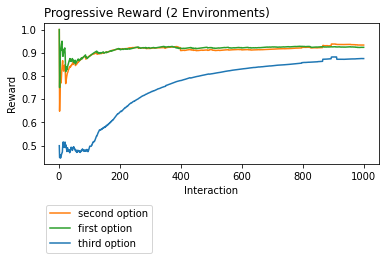

In [9]:
labels=['third option','second option','first option','ground truth']
result2.filter_fin(1000).plot_learners(l=['ope_reward','eval_type'],p='openml_task',labels=labels)

In this plot the third option looks pretty good. It almost perfectly matches the average online performance across 75 unique classification datasets. Unfortunately, this plot isn't the full story. To get this accuracy we had to sacrafice some data. Notice that the plot above only has 1,000 interactions but our original dataset had 100,000 examples.

We now create a plot that shows the all 100,000 examples so we can see how much data we threw out when using the ExplorationEvaluator.

Every openml_task not present for all ['ope_reward', 'eval_type'] has been excluded.
Interactions beyond the shortest openml_task have been excluded.
There was no openml_task which was finished for every ['ope_reward', 'eval_type'].
This result does not contain any data to plot.


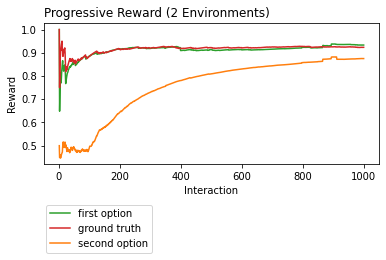

In [10]:
labels=['second option','first option','ground truth']

result2\
    .filter_val(eval_type={'!=':'ExplorationEvaluator'})\
    .plot_learners(l=['ope_reward','eval_type'],p='openml_task',labels=labels,colors=[1,2,3],out=None)

result2\
    .filter_val(eval_type={'=':'ExplorationEvaluator'})\
    .filter_fin(1000,['ope_reward','eval_type'],'openml_task')\
    .plot_learners(labels='third option',colors=0)